In [1]:
import os
import pandas as pd
import numpy as np
import talib
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

pd.set_option('display.max_columns', None)

In [2]:
def load_data(file_names):
    dfs = []
    for file_name in file_names:
        df = pd.read_csv(file_name)
        dfs.append(df)
    return dfs

In [3]:
def feature_engineering(df, prefix):
    open = df[f'{prefix}_open_bid'].values
    high = df[f'{prefix}_high_bid'].values
    low = df[f'{prefix}_low_bid'].values
    close = df[f'{prefix}_close_bid'].values
    # volume = df[f'{prefix}_volume'].values
    hilo = (high + low) / 2

    df[f'{prefix}_RSI_ST'] = talib.RSI(close)/close
    df[f'{prefix}_RSI_LOG'] = log_transform_feature(talib.RSI(close))
    df[f'{prefix}_MACD'], _, _ = talib.MACD(close)
    df[f'{prefix}_MACD_ST'], _, _ = talib.MACD(close)/close
    df[f'{prefix}_ATR'] = talib.ATR(high, low, close)
    df[f'{prefix}_ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df[f'{prefix}_ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    
    df[f'{prefix}_SMA10'] = talib.SMA(close, timeperiod=10)
    df[f'{prefix}_SMA50'] = talib.SMA(close, timeperiod=50)
    df[f'{prefix}_SMA200'] = talib.SMA(close, timeperiod=200)
    
    df[f'{prefix}_BB_UPPER'], df[f'{prefix}_BB_MIDDLE'], df[f'{prefix}_BB_LOWER'] = talib.BBANDS(close)
    df[f'{prefix}_BBANDS_upperband'] = (df[f'{prefix}_BB_UPPER'] - hilo) / close
    df[f'{prefix}_BBANDS_middleband'] = (df[f'{prefix}_BB_MIDDLE'] - hilo) / close
    df[f'{prefix}_BBANDS_lowerband'] = (df[f'{prefix}_BB_LOWER'] - hilo) / close
    df[f'{prefix}_STOCH_K'], df[f'{prefix}_STOCH_D'] = talib.STOCH(high, low, close)/close
    df[f'{prefix}_MON'] = talib.MOM(close, timeperiod=5)
    # df[f'{prefix}_OBV'] = talib.OBV(close, volume)

    df = df.dropna()
    df = df.reset_index(drop=True)

    return df

def log_transform_feature(X):
    X[X <= 0] = np.finfo(float).eps
    return np.log(X)

def create_label(df, prefix, lookahead=1):
    df[f'{prefix}_target'] = (df[f'{prefix}_close_bid'].shift(-lookahead) > df[f'{prefix}_close_bid']).astype(int)
    df = df.dropna()
    return df

In [4]:
def plot_learning_curve(evals_result):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(np.arange(len(evals_result['training']['binary_error'])),
            evals_result['training']['binary_error'], label='Training')
    ax.plot(np.arange(len(evals_result['valid_1']['binary_error'])),
            evals_result['valid_1']['binary_error'], label='Validation')
    ax.set_title('Learning Curve')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Binary Error')
    ax.legend()
    plt.show()

def plot_feature_importance(importances, feature_names):
    importance = pd.DataFrame({"Feature": feature_names,
                               "Importance": importances})
    importance.sort_values(by="Importance", ascending=False, inplace=True)
    plt.figure(figsize=(15, 15))
    sns.barplot(x="Importance", y="Feature", data=importance)
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()

In [5]:
target_feature = "5T_target"

# def prepare_data(df):
#     features = df.drop(target_feature, axis=1)
#     labels = df[target_feature]

#     X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

#     return X_train, X_val, y_train, y_val

def train_and_evaluate(df, n_splits=5):
    df = df.drop(df.filter(regex='_ask').columns, axis=1)
    features = df.drop([target_feature], axis=1)
    labels = df[target_feature]

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    feature_importances = []

    for train_index, test_index in kf.split(features):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]

        train_data = lgb.Dataset(X_train, label=y_train)
        test_data = lgb.Dataset(X_test, label=y_test)

        params = {
            'objective': 'binary',
            'metric': 'binary_error',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.9
        }

        evals_result = {}

        model = lgb.train(
            params=params,
            train_set=train_data,
            valid_sets=[train_data, test_data],
            num_boost_round=10000,
            callbacks=[
                lgb.callback.early_stopping(10),
                lgb.callback.log_evaluation(period=100),
                lgb.callback.record_evaluation(evals_result)
            ],
        )

        y_pred = model.predict(X_test)
        y_pred = np.round(y_pred).astype(int)

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        print(f"Accuracy: {accuracy}")
        print(classification_report(y_test, y_pred))
        
        plot_learning_curve(evals_result)
        feature_importances.append(model.feature_importance())
    
    mean_accuracy = np.mean(accuracies)
    print(f"Mean accuracy: {mean_accuracy}")

    mean_importance = np.mean(feature_importances, axis=0)
    plot_feature_importance(mean_importance, features.columns)

    return model, evals_result

In [6]:
def resample_data(df):
    # Set the date column as the index
    df.set_index('date', inplace=True)
    
    # Convert the index to datetime
    df.index = pd.to_datetime(df.index)

    # Resample data to different timeframes
    timeframes = ['1T', '5T', '15T', '1H', '4H', '1D']

    resampled_dfs = []

    for tf in timeframes:
        resampled = df.resample(tf).agg({'open_bid': 'first', 'high_bid': 'max', 'low_bid': 'min', 'close_bid': 'last',
                                         'open_ask': 'first', 'high_ask': 'max', 'low_ask': 'min', 'close_ask': 'last'})
        resampled.dropna(inplace=True)
        resampled.columns = [f"{tf}_{col}" for col in resampled.columns]
        prefix = resampled.columns[0].split('_')[0]
        processed_df = feature_engineering(resampled, prefix)
        processed_df = create_label(processed_df, prefix, 15)
        resampled_dfs.append(processed_df)

    # Combine resampled data
    combined_resampled = pd.concat(resampled_dfs, axis=1).dropna()
    return combined_resampled

,1T_open_bid,1T_high_bid,1T_low_bid,1T_close_bid,1T_open_ask,1T_high_ask,1T_low_ask,1T_close_ask,1T_RSI_ST,1T_RSI_LOG,1T_MACD,1T_MACD_ST,1T_ATR,1T_ADX,1T_ADXR,1T_SMA10,1T_SMA50,1T_SMA200,1T_BB_UPPER,1T_BB_MIDDLE,1T_BB_LOWER,1T_BBANDS_upperband,1T_BBANDS_middleband,1T_BBANDS_lowerband,1T_STOCH_K,1T_STOCH_D,1T_MON,1T_target,5T_open_bid,5T_high_bid,5T_low_bid,5T_close_bid,5T_open_ask,5T_high_ask,5T_low_ask,5T_close_ask,5T_RSI_ST,5T_RSI_LOG,5T_MACD,5T_MACD_ST,5T_ATR,5T_ADX,5T_ADXR,5T_SMA10,5T_SMA50,5T_SMA200,5T_BB_UPPER,5T_BB_MIDDLE,5T_BB_LOWER,5T_BBANDS_upperband,5T_BBANDS_middleband,5T_BBANDS_lowerband,5T_STOCH_K,5T_STOCH_D,5T_MON,5T_target,15T_open_bid,15T_high_bid,15T_low_bid,15T_close_bid,15T_open_ask,15T_high_ask,15T_low_ask,15T_close_ask,15T_RSI_ST,15T_RSI_LOG,15T_MACD,15T_MACD_ST,15T_ATR,15T_ADX,15T_ADXR,15T_SMA10,15T_SMA50,15T_SMA200,15T_BB_UPPER,15T_BB_MIDDLE,15T_BB_LOWER,15T_BBANDS_upperband,15T_BBANDS_middleband,15T_BBANDS_lowerband,15T_STOCH_K,15T_STOCH_D,15T_MON,15T_target,1H_open_bid,1H_high_bid,1H_low_bid,1H_close_bid,1H_open_ask,1H_high_ask,1H_low_ask,1H_close_ask,1H_RSI_ST,1H_RSI_LOG,1H_MACD,1H_MACD_ST,1H_ATR,1H_ADX,1H_ADXR,1H_SMA10,1H_SMA50,1H_SMA200,1H_BB_UPPER,1H_BB_MIDDLE,1H_BB_LOWER,1H_BBANDS_upperband,1H_BBANDS_middleband,1H_BBANDS_lowerband,1H_STOCH_K,1H_STOCH_D,1H_MON,1H_target,4H_open_bid,4H_high_bid,4H_low_bid,4H_close_bid,4H_open_ask,4H_high_ask,4H_low_ask,4H_close_ask,4H_RSI_ST,4H_RSI_LOG,4H_MACD,4H_MACD_ST,4H_ATR,4H_ADX,4H_ADXR,4H_SMA10,4H_SMA50,4H_SMA200,4H_BB_UPPER,4H_BB_MIDDLE,4H_BB_LOWER,4H_BBANDS_upperband,4H_BBANDS_middleband,4H_BBANDS_lowerband,4H_STOCH_K,4H_STOCH_D,4H_MON,4H_target,1D_open_bid,1D_high_bid,1D_low_bid,1D_close_bid,1D_open_ask,1D_high_ask,1D_low_ask,1D_close_ask,1D_RSI_ST,1D_RSI_LOG,1D_MACD,1D_MACD_ST,1D_ATR,1D_ADX,1D_ADXR,1D_SMA10,1D_SMA50,1D_SMA200,1D_BB_UPPER,1D_BB_MIDDLE,1D_BB_LOWER,1D_BBANDS_upperband,1D_BBANDS_middleband,1D_BBANDS_lowerband,1D_STOCH_K,1D_STOCH_D,1D_MON,1D_target
0,2496.8,2498.5,2496.8,2497.8,2497.2,2498.9,2497.2,2498.3,0.010627,3.278789,-2.995239,-0.001199,1.614862,65.454188,66.591561,2500.55,2508.998,2515.5560,2501.653134,2498.86,2496.066866,0.001603,0.000484,-0.000634,0.009752,0.009912,-1.5,0,2482.0,2485.3,2481.9,2485.0,2482.4,2485.8,2482.2,2485.3,0.024647,4.114909,4.714899,0.001897,4.597092,31.501018,23.291882,2484.57,2472.642,2483.9845,2491.376988,2486.00,2480.623012,0.003130,0.000966,-0.001198,0.008772,0.017474,-6.0,1.0,2458.5,2461.6,2458.1,2460.2,2458.8,2462.0,2458.5,2460.6,0.023385,4.052333,0.659214,0.000268,5.487730,19.678555,23.856150,2455.60,2458.952,2477.7935,2460.644162,2458.72,2456.795838,0.000323,-0.000459,-0.001241,0.028375,0.028630,2.3,1.0,2575.7,2581.6,2570.5,2577.9,2576.0,2581.9,2570.9,2578.2,0.018711,3.876105,-3.154068,-0.001224,5.913445,25.672084,20.317755,2573.70,2583.744,2540.4670,2579.230302,2574.10,2568.969698,0.001234,-0.000756,-0.002747,0.027020,0.023471,5.2,1.0,2778.0,2778.8,2773.2,2776.4,2778.4,2779.3,2773.5,2776.7,0.023789,4.190394,12.183567,0.004388,11.411274,29.180629,32.332676,2759.64,2732.224,2644.5400,2783.957297,2775.08,2766.202703,0.002866,-0.000331,-0.003529,0.030298,0.032427,9.4,1.0,2905.8,2936.5,2901.0,2917.5,2906.2,2936.9,2901.4,2918.0,0.016652,3.883253,-13.321711,-0.004566,41.351658,32.313371,32.583578,2901.15,2957.540,2839.4395,2930.260126,2917.54,2904.819874,0.003945,-0.000415,-0.004775,0.021141,0.025667,25.9,1.0
1,2497.7,2498.4,2496.9,2497.9,2498.2,2498.8,2497.3,2498.3,0.010854,3.299980,-2.991156,-0.001197,1.606657,66.002532,66.556529,2499.83,2508.596,2515.5020,2500.735205,2498.36,2495.984795,0.001235,0.000284,-0.000667,0.011743,0.010176,-2.5,0,2485.5,2493.5,2485.5,2492.5,2486.0,2494.0,2486.0,2492.8,0.027463,4.226138,5.158734,0.002070,4.875871,32.750453,24.399843,2486.12,2473.078,2483.8720,2494.226439,2486.80,2479.373561,0.001896,-0.001083,-0.004063,0.014753,0.013327,4.0,1.0,2460.2,2460.5,2457.5,2460.0,2460.6,2461.1,2457.8,2460.4,0.023259,4.046857,0.988366,0.000402,5.310035,19.560377,24.121253,2456.95,2458.348,24

[LightGBM] [Info] Number of positive: 503, number of negative: 394
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35037
[LightGBM] [Info] Number of data points in the train set: 897, number of used features: 143
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.560758 -> initscore=0.244239
[LightGBM] [Info] Start training from score 0.244239
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	training's binary_error: 0.03233	valid_1's binary_error: 0.0977778
Accuracy: 0.9022222222222223
              precision    recall  f1-score   support

         0.0       0.94      0.82      0.88        97
         1.0       0.88      0.96      0.92       128

    accuracy                           0.90       225
   macro avg       0.91      0.89      0.90       225
weighted avg       0.91      0.90      0

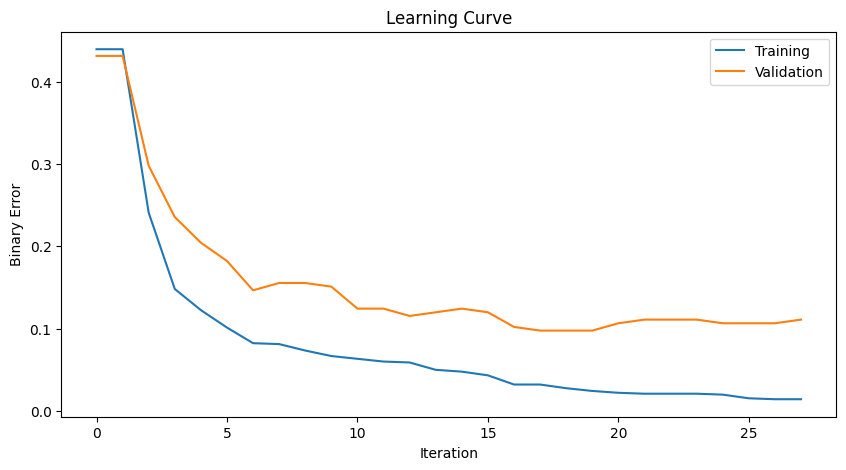

[LightGBM] [Info] Number of positive: 505, number of negative: 392
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35031
[LightGBM] [Info] Number of data points in the train set: 897, number of used features: 143
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.562988 -> initscore=0.253297
[LightGBM] [Info] Start training from score 0.253297
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	training's binary_error: 0.0245262	valid_1's binary_error: 0.106667
Accuracy: 0.8933333333333333
              precision    recall  f1-score   support

         0.0       0.90      0.85      0.88        99
         1.0       0.89      0.93      0.91       126

    accuracy                           0.89       225
   macro avg       0.89      0.89      0.89       225
weighted avg       0.89      0.89      

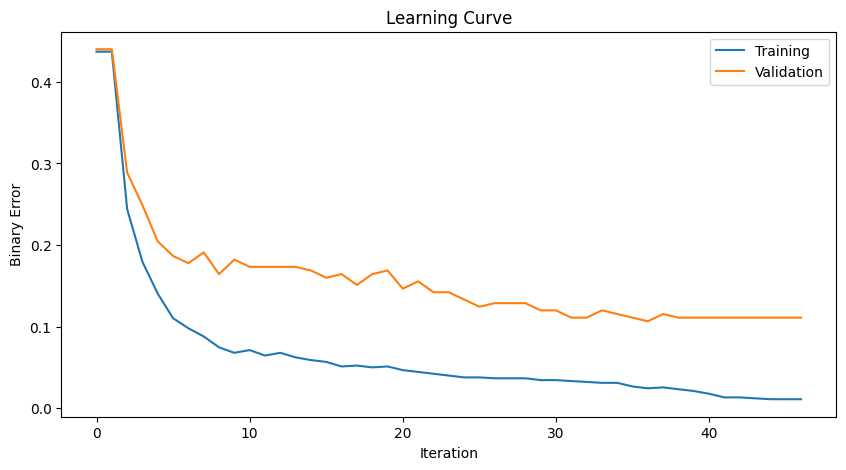

[LightGBM] [Info] Number of positive: 501, number of negative: 397
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35044
[LightGBM] [Info] Number of data points in the train set: 898, number of used features: 143
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.557906 -> initscore=0.232670
[LightGBM] [Info] Start training from score 0.232670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	training's binary_error: 0.05902	valid_1's binary_error: 0.142857
Accuracy: 0.8571428571428571
              precision    recall  f1-score   support

         0.0       0.86      0.79      0.82        94
         1.0       0.86      0.91      0.88       130

    accuracy                           0.86       224
   macro avg       0

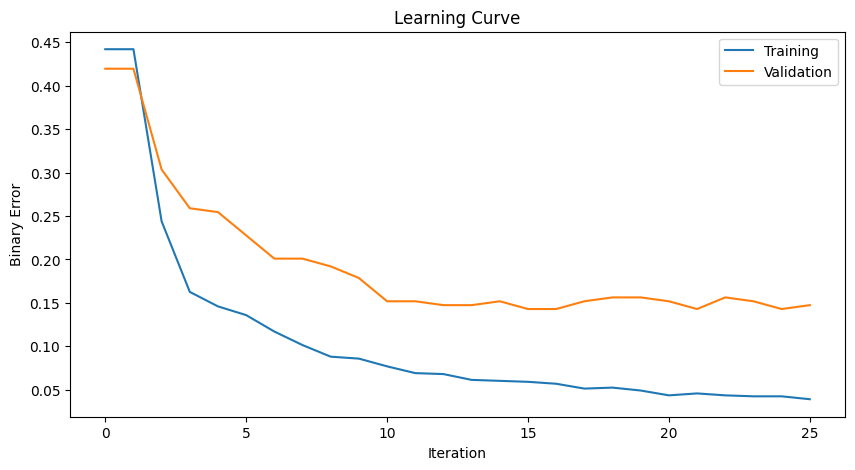

[LightGBM] [Info] Number of positive: 512, number of negative: 386
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35030
[LightGBM] [Info] Number of data points in the train set: 898, number of used features: 143
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.570156 -> initscore=0.282487
[LightGBM] [Info] Start training from score 0.282487
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	training's binary_error: 0.0300668	valid_1's binary_error: 0.120536
Accuracy: 0.8794642857142857
              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86       105
         1.0       0.84      0.95      0.89       119

    accuracy                           0.88       224
   macro avg       0.89      0.87      0.88       224
weighted avg       0.89      0.88      

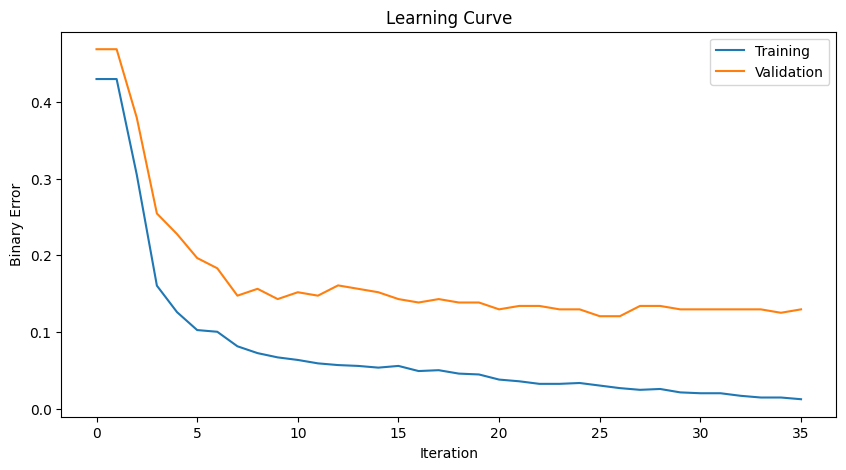

[LightGBM] [Info] Number of positive: 503, number of negative: 395
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35030
[LightGBM] [Info] Number of data points in the train set: 898, number of used features: 143
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.560134 -> initscore=0.241704
[LightGBM] [Info] Start training from score 0.241704
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	training's binary_error: 0.0445434	valid_1's binary_error: 0.102679
Accuracy: 0.8973214285714286
              precision    recall  f1-score   support

         0.0       0.92      0.83      0.87        96
         1.0       0.88      0.95      0.91       128

    accuracy                           0.90       224
   macro avg       0.90      0.89      0.89       224
weighted avg       0.90      0.90      

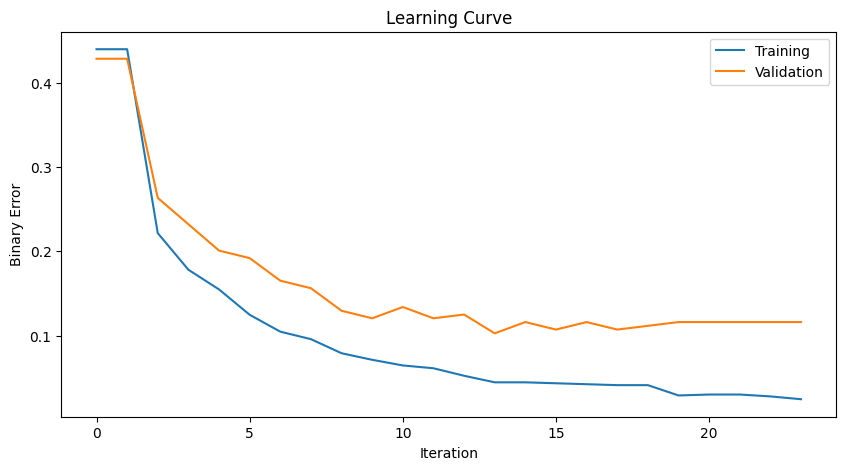

Mean accuracy: 0.8858968253968253


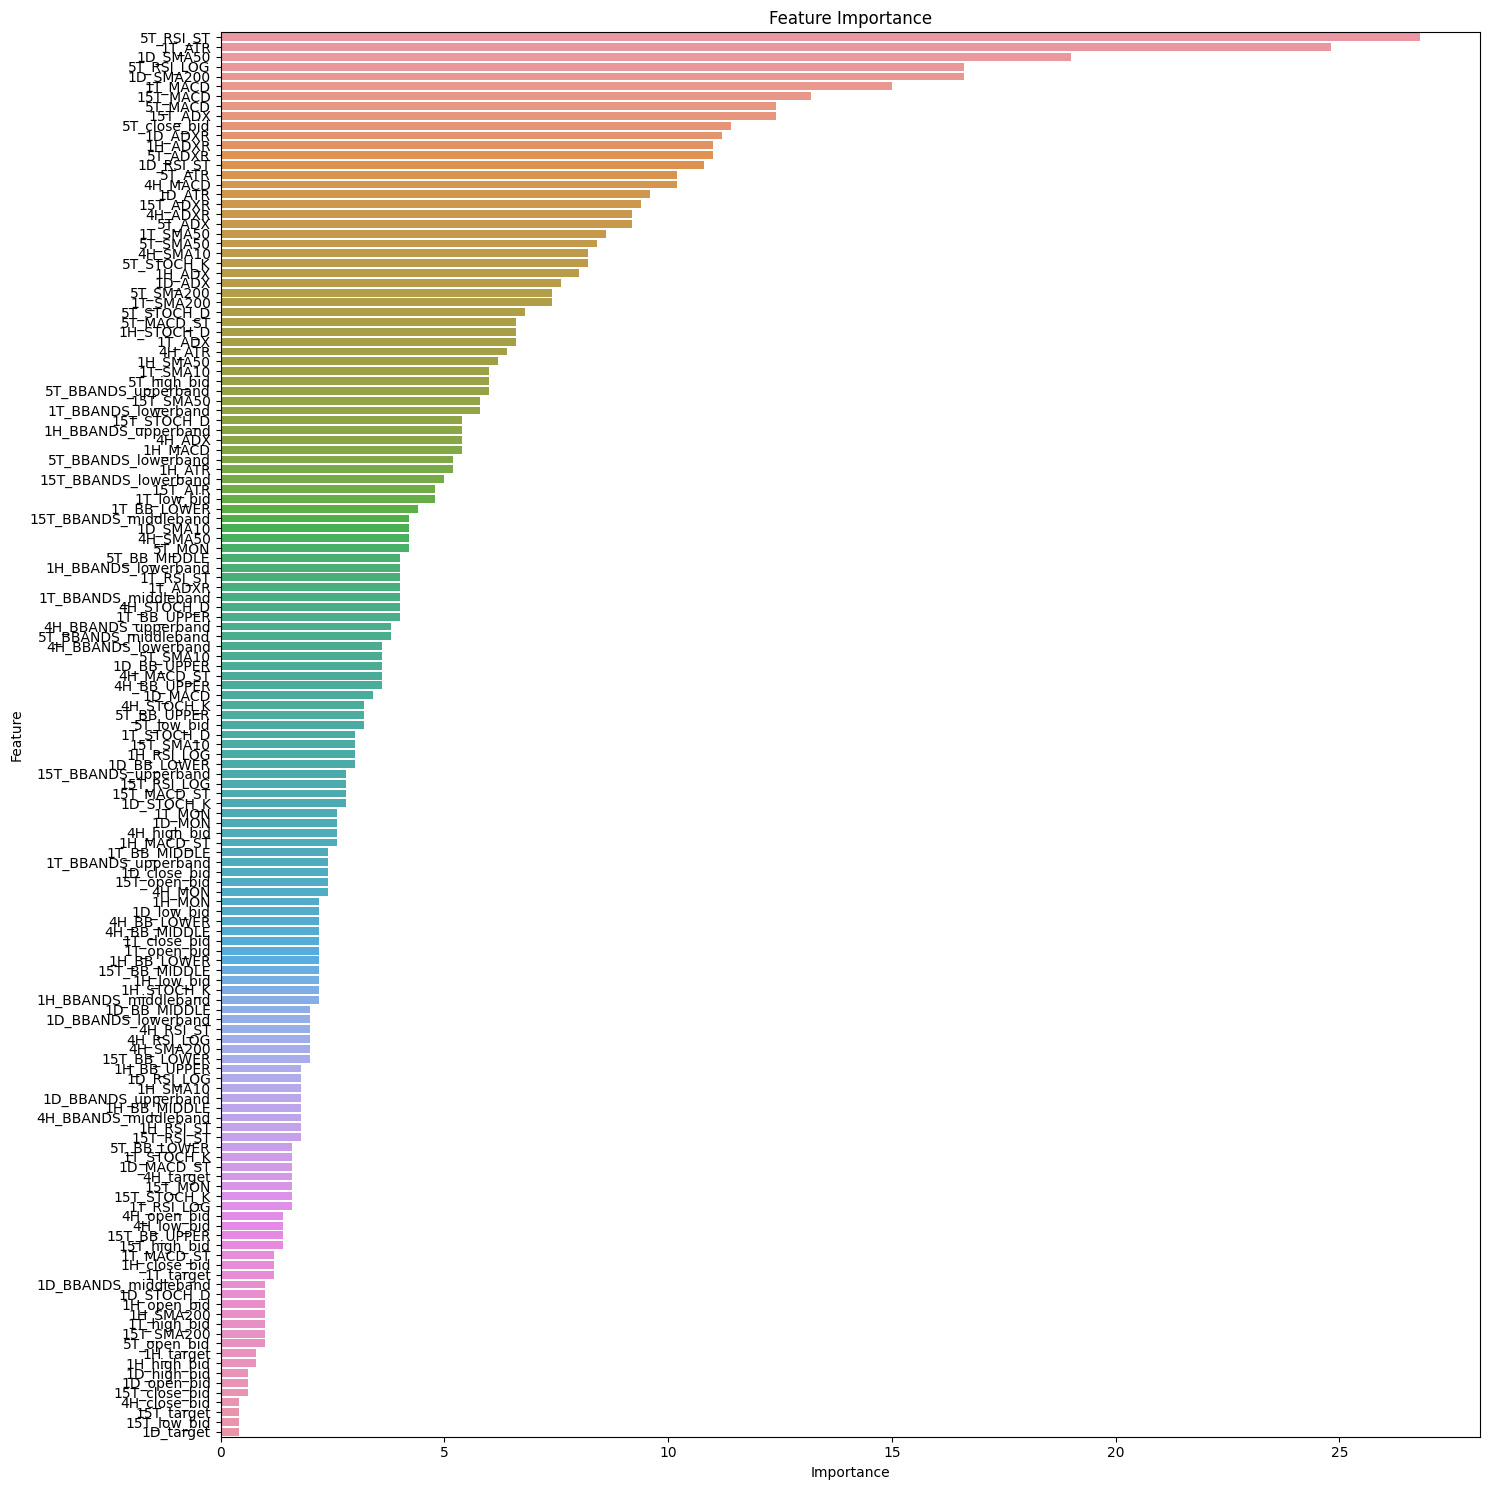

Model saved to model/test_model.pkl


In [7]:
if __name__ == "__main__":
    file_names = ["combined_data.csv"]
    dfs = load_data(file_names)
    
    # Assuming you have only one DataFrame in the list
    combined_df = dfs[0]
    combined_df = resample_data(combined_df)
    display(combined_df)

    model, evals_result = train_and_evaluate(combined_df)
    model_path = os.path.join("model", "test_model.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(model, f)

    print(f"Model saved to {model_path}")